In [1]:
import xarray as xr

In [2]:
data = '/home/ubuntu/data/ds810.0/pr_day_CCSM4_historical_r1i1p1_19550101-19891231.nc'

In [3]:
ds = xr.open_dataset(data)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, time: 12775)
Coordinates:
  * time       (time) datetime64[ns] 1955-01-01T12:00:00 1955-01-02T12:00:00 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float64 ...
Attributes:
    institution:                  NCAR (National Center for Atmospheric Resea...
    institute_id:                 NCAR
    experiment_id:                historical
    source:                       CCSM4
    model_id:                     CCSM4
    forcing:                      Sl GHG Vl SS Ds SD BC MD OC Oz AA LU
    parent_experiment_id:         piControl
    parent_experiment_rip:        r1i1p1
    branch_time:                  937.0
  

In [5]:
dset = ds['pr'].isel(time=slice(0, 5000))

In [6]:
dset

<xarray.DataArray 'pr' (time: 5000, lat: 192, lon: 288)>
[276480000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1955-01-01T12:00:00 1955-01-02T12:00:00 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
Attributes:
    standard_name:     precipitation_flux
    long_name:         Precipitation
    comment:           PRECC + PRECL and unit conversion, CMIP5_table_comment...
    units:             kg m-2 s-1
    original_name:     PRECC,PRECL
    cell_methods:      time: mean (interval: 1 day)
    cell_measures:     area: areacella
    history:           2011-11-07T22:10:53Z altered by CMOR: Reordered dimens...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [7]:
data = dset.values
data.shape

(5000, 192, 288)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

In [9]:
data = data.reshape((len(data), np.prod(data.shape[1:])))
data.shape

(5000, 55296)

In [10]:
x_train, x_test = train_test_split(data, test_size=0.2)

In [11]:
x_train.shape, x_test.shape

((4000, 55296), (1000, 55296))

In [14]:
from keras import layers
from keras import models
from keras import regularizers
from keras import losses
from keras import callbacks
from math import sqrt

/home/ubuntu/miniconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
activity_reg = regularizers.l1(0.0001)
kernel_reg = regularizers.l1(0.00001)

In [14]:
image_dim = x_train.shape[1]
encoded_dim = 1800

In [15]:
# this the input placeholder
input_img = layers.Input(shape=(image_dim, ))
encoded = layers.Dense(
    encoded_dim,
    activation='selu',
    activity_regularizer=activity_reg,
    kernel_regularizer=kernel_reg,
    name="encoded")(input_img)
# Decoded is thelossy reconstruction of the input
decoded = layers.Dense(
    image_dim, activation='sigmoid', name="decoded")(encoded)

In [16]:
# This model maps an input to its reconstruction 
model = models.Model(input_img, decoded)
# This model maps an input to tis encoded representation
encoder = models.Model(input_img, encoded)
# Create a placeholder for an encoded (324-dimensional) input
encoded_input = layers.Input(shape=(encoded_dim, ))
# Retrieve the last layer of the autoencoder model
decoded_layer = model.layers[-1]
# Create the decoder model
decoder = models.Model(encoded_input, decoded_layer(encoded_input))

In [18]:
from keras_sequential_ascii import sequential_model_to_ascii_printout as print_model

In [18]:
print_model(encoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####       55296
          InputLayer     |   -------------------         0     0.0%
                       #####       55296
               Dense   XXXXX -------------------  99534600   100.0%
                selu   #####        1800


In [19]:
print_model(decoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1800
          InputLayer     |   -------------------         0     0.0%
                       #####        1800
               Dense   XXXXX -------------------  99588096   100.0%
             sigmoid   #####       55296


In [20]:
print_model(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####       55296
          InputLayer     |   -------------------         0     0.0%
                       #####       55296
               Dense   XXXXX -------------------  99534600    50.0%
                selu   #####        1800
               Dense   XXXXX -------------------  99588096    50.0%
             sigmoid   #####       55296


In [38]:
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=5)]

In [22]:
model.compile(optimizer="rmsprop", loss = losses.binary_crossentropy)

In [23]:
%%time
history = model.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=64,
    shuffle=True,
    callbacks=callbacks_list,
    validation_data=(x_test, x_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 30s 7ms/step - loss: 1.3547 - val_loss: 1.1805
Epoch 2/20
4000/4000 [==============================] - 19s 5ms/step - loss: 1.1447 - val_loss: 1.1048
Epoch 3/20
4000/4000 [==============================] - 19s 5ms/step - loss: 1.1144 - val_loss: 1.1200
Epoch 4/20
4000/4000 [==============================] - 19s 5ms/step - loss: 1.0848 - val_loss: 1.0488
Epoch 5/20
4000/4000 [==============================] - 19s 5ms/step - loss: 0.9753 - val_loss: 0.8475
Epoch 6/20
4000/4000 [==============================] - 19s 5ms/step - loss: 0.7662 - val_loss: 0.7024
Epoch 7/20
4000/4000 [==============================] - 19s 5ms/step - loss: 0.6910 - val_loss: 0.6753
Epoch 8/20
4000/4000 [==============================] - 19s 5ms/step - loss: 0.6511 - val_loss: 0.6221
Epoch 9/20
4000/4000 [==============================] - 19s 5ms/step - loss: 0.6262 - val_loss: 0.6232
Epoch 10/20
4000/4000 [==

In [44]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
%matplotlib inline

In [25]:
def predict_test():
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    print("Mean activations: {}".format(encoded_imgs.mean()))

    indices = np.random.choice(len(x_test), 5)

    n = len(indices)

    fig = plt.figure(figsize=(20, 4))

    rows = 3

    side = int(np.sqrt(encoded_dim))

    for i in range(n):

        # display original
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(x_test[indices[i]].reshape(192, 288))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoding
        ax = plt.subplot(rows, n, i + 1 + n)
        plt.imshow(((encoded_imgs[indices[i]] + 1) / 2).reshape(40, 45))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(rows, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[indices[i]].reshape(192, 288))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Mean activations: 0.0034683903213590384


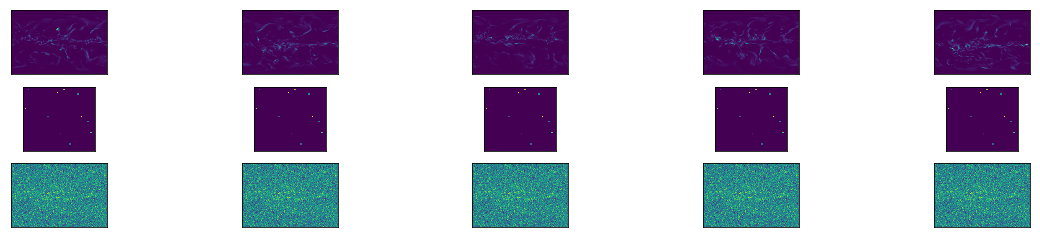

In [26]:
predict_test()

In [51]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


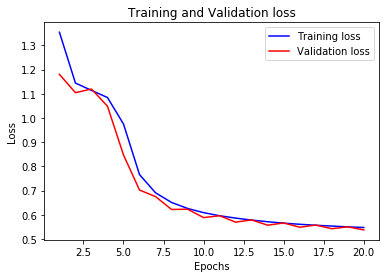

In [28]:
plot_history(history)

# Convolution Autoencoder

In [11]:
x_train = x_train.reshape(4000, 192, 288, 1)
x_test = x_test.reshape(1000, 192, 288, 1)

In [12]:
x_train.shape

(4000, 192, 288, 1)

In [15]:
input_img = layers.Input(shape=(x_train.shape[1], x_train.shape[2], 1))

In [33]:
input_img.shape

TensorShape([Dimension(None), Dimension(192), Dimension(288), Dimension(1)])

In [55]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(16, (3, 3), activation='tanh', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(16, (3, 3), activation='tanh', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(16, (3, 3), activation='tanh', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [56]:
print_model(autoencoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    192  288    1
          InputLayer     |   -------------------         0     0.0%
                       #####    192  288    1
              Conv2D    \|/  -------------------       320     1.9%
                relu   #####    192  288   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     96  144   32
             Dropout    | || -------------------         0     0.0%
                       #####     96  144   32
              Conv2D    \|/  -------------------      4624    27.5%
                relu   #####     96  144   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     48   72   16
             Dropout    | || -------------------         0     0.0%
                       #####     48   72   16
              Conv2D    \|/  -------------------      2320    13.8%
              

In [57]:
%%time
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    callbacks=callbacks_list,
    validation_data=(x_test, x_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 36s 9ms/step - loss: 0.0039 - val_loss: 4.4654e-04
Epoch 2/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4595e-04 - val_loss: 4.4654e-04
Epoch 3/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4571e-04 - val_loss: 4.4654e-04
Epoch 4/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4568e-04 - val_loss: 4.4654e-04
Epoch 5/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4567e-04 - val_loss: 4.4654e-04
Epoch 6/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4567e-04 - val_loss: 4.4654e-04
Epoch 7/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4567e-04 - val_loss: 4.4654e-04
Epoch 8/20
4000/4000 [==============================] - 32s 8ms/step - loss: 4.4567e-04 - val_loss: 4.4654e-04
Epoch 9/20
4000/4000 [==============================] - 32s 8ms/step

In [58]:
def predict_test():
    #encoded_imgs = encoder.predict(x_test)
    decoded_imgs = autoencoder.predict(x_test)

    #print("Mean activations: {}".format(encoded_imgs.mean()))

    indices = np.random.choice(len(x_test), 5)

    n = len(indices)

    fig = plt.figure(figsize=(20, 4))

    rows = 2


    for i in range(n):

        # display original
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(x_test[indices[i]].reshape(192, 288))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoding
    
        #ax = plt.subplot(rows, n, i + 1 + n)
        #plt.imshow(((encoded_imgs[indices[i]] + 1) / 2).reshape(40, 45))
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(rows, n, i + 1 + 1 * n)
        plt.imshow(decoded_imgs[indices[i]].reshape(192, 288))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

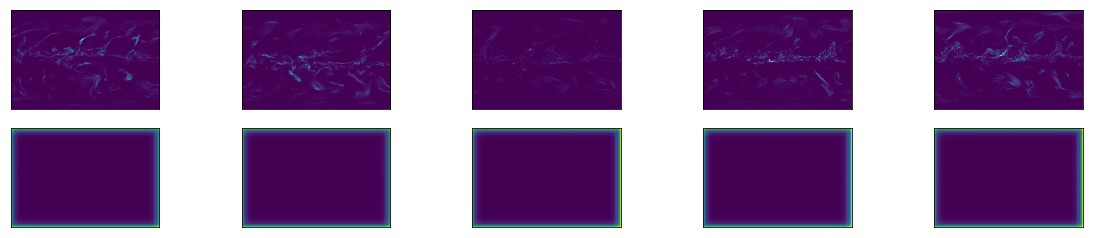

In [59]:
predict_test()

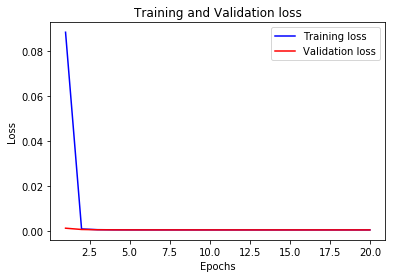

In [52]:
plot_history(history)

In [60]:
decoded_imgs = autoencoder.predict(x_test)

In [61]:
decoded_imgs.shape

(1000, 192, 288, 1)

In [62]:
decoded_imgs.mean(axis=0)

array([[[-0.00871749],
        [-0.01215462],
        [-0.01158725],
        ...,
        [-0.01270217],
        [-0.01365528],
        [-0.00863684]],

       [[-0.01190931],
        [-0.01805813],
        [-0.01805169],
        ...,
        [-0.01840965],
        [-0.01869373],
        [-0.01119487]],

       [[-0.01387526],
        [-0.02275929],
        [-0.02323161],
        ...,
        [-0.02342403],
        [-0.02244235],
        [-0.0114282 ]],

       ...,

       [[-0.01879576],
        [-0.03073861],
        [-0.03329993],
        ...,
        [-0.02310143],
        [-0.02148598],
        [-0.01270737]],

       [[-0.01754911],
        [-0.0266253 ],
        [-0.0280674 ],
        ...,
        [-0.01906501],
        [-0.01818792],
        [-0.01130678]],

       [[-0.01436894],
        [-0.0191756 ],
        [-0.02112992],
        ...,
        [-0.01553699],
        [-0.0147846 ],
        [-0.00969975]]], dtype=float32)

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
mean_squared_error(x_test.reshape(1000, 192*288), decoded_imgs.reshape(1000, 192*288))

0.003129820333692413